# Importing modules

In [1]:
import pandas as pd
import torch
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from nca_implementation.torchnca import nca
import matplotlib.pyplot as plt
import numpy as np

# Loading data

In [2]:
# Read pickles
df_m67 = pd.read_pickle('./data/oc_Messier_67_candidates.pickle')
df_m44 = pd.read_pickle('./data/oc_Messier_44_candidates.pickle')

# Filter based on fidelity_v2 >= 0.7
df_m67 = df_m67[df_m67['fidelity_v2'] >= 0.7]
df_m44 = df_m44[df_m44['fidelity_v2'] >= 0.7]

# Select only relevant columns
SELECTED_COLS = ['ra', 'dec', 'pmra', 'pmdec', 'r_med_geo', 'fidelity_v2', 'cluster_flag'] 
df_m67 = df_m67[SELECTED_COLS]
df_m44 = df_m44[SELECTED_COLS]

# Set cluster candidate information
"""
0 - M67_NOCLUSTER
1 - M67_CLUSTER
2 - M44_NOCLUSTER
3 - M44_CLUSTER
"""
df_m67.loc[df_m67.cluster_flag == 0, 'cluster_flag'] = 0
df_m67.loc[df_m67.cluster_flag == 1, 'cluster_flag'] = 1

df_m44.loc[df_m44.cluster_flag == 0, 'cluster_flag'] = 2
df_m44.loc[df_m44.cluster_flag == 1, 'cluster_flag'] = 3

# Join the data
df = pd.concat([df_m67, df_m44])

In [3]:
print("-------- Messier-67 Cluster Flag Counts --------")
print(df_m67['cluster_flag'].value_counts())

print()

print("-------- Messier-44 Cluster Flag Counts --------")
print(df_m44['cluster_flag'].value_counts())

-------- Messier-67 Cluster Flag Counts --------
cluster_flag
0    86737
1      974
Name: count, dtype: int64

-------- Messier-44 Cluster Flag Counts --------
cluster_flag
2    83565
3      679
Name: count, dtype: int64


In [4]:
print("-------- COLUMN INFORMATION --------")
df.info()

-------- COLUMN INFORMATION --------
<class 'pandas.core.frame.DataFrame'>
Index: 171955 entries, 1 to 110831
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   ra            171955 non-null  float64
 1   dec           171955 non-null  float64
 2   pmra          171955 non-null  float64
 3   pmdec         171955 non-null  float64
 4   r_med_geo     171955 non-null  float32
 5   fidelity_v2   171955 non-null  float32
 6   cluster_flag  171955 non-null  int64  
dtypes: float32(2), float64(4), int64(1)
memory usage: 9.2 MB


In [5]:
df.head()

,ra,dec,pmra,pmdec,r_med_geo,fidelity_v2,cluster_flag
1,132.460820,9.354456,-4.467221,11.077062,1299.076538,0.989258,0
2,132.447898,9.347820,-20.515164,5.789698,259.710754,1.000000,0
3,132.422902,9.353250,-11.516026,-1.922608,538.822510,0.993164,0
4,132.399934,9.357089,-5.521866,-9.747638,1644.195190,0.965820,0
5,132.413950,9.358508,-2.926452,5.010006,844.427246,0.966797,0


# Train-test split

In [11]:
# Selecting 30 rows at random
# df = df.loc[~df['cluster_flag'].isin([1, 3])].sample(n=30, random_state=42)

# Splitting into features (X) and labels (y)
X = torch.tensor(df.drop(labels=['cluster_flag', 'dec'], axis=1).values, dtype=torch.float32)
y = torch.tensor(df['cluster_flag'].copy().values)

poly = PolynomialFeatures(2, include_bias=False, interaction_only=True)

X = torch.tensor(poly.fit_transform(X), dtype=torch.float32)

# Stratified Train-test split (based on labels)
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

# Define where computations will take place (GPU or CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Move train data to device
X_train.to(device)
y_train.to(device)

tensor([2, 2, 2,  ..., 2, 2, 2], device='cuda:0')

In [12]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

torch.Size([137564, 15]) torch.Size([137564]) torch.Size([34391, 15]) torch.Size([34391])


In [13]:
print("-------- TRAIN DATASET LABEL PERCENTAGES --------")
y_train_uniques, y_train_unique_counts = y_train.unique(return_counts=True)
y_train_total = torch.sum(y_train_unique_counts).item()

for item, count in zip(y_train_uniques, y_train_unique_counts):
    print(f"{item}: {(count / y_train_total) * 100:.4f}%")

print("Total Samples: " + str(y_train_total))

print()

print("-------- TEST DATASET LABEL PERCENTAGES --------")
y_test_uniques, y_test_unique_counts = y_test.unique(return_counts=True)
y_test_total = torch.sum(y_test_unique_counts).item()

for item, count in zip(y_test_uniques, y_test_unique_counts):
    print(f"{item}: {(count / y_test_total) * 100:.4f}%")

print("Total Samples: " + str(y_test_total))

-------- TRAIN DATASET LABEL PERCENTAGES --------
0: 50.4420%
1: 0.5663%
2: 48.5970%
3: 0.3947%
Total Samples: 137564

-------- TEST DATASET LABEL PERCENTAGES --------
0: 50.4405%
1: 0.5670%
2: 48.5970%
3: 0.3955%
Total Samples: 34391


In [15]:
nca_pipeline = nca.NCALinear(dim=2, max_iters=100)
nca_pipeline.train(X_train, y_train, batch_size=256, lr=1e-6)

using random init
epoch: 1 - loss: 329.20740
epoch: 1 - loss: 299.87207
epoch: 1 - loss: 290.58777
epoch: 1 - loss: 291.16705
epoch: 1 - loss: 263.35663
epoch: 1 - loss: 254.79108
epoch: 1 - loss: 248.68402
epoch: 1 - loss: 215.68304
epoch: 1 - loss: 202.34380
epoch: 1 - loss: 199.23671
epoch: 1 - loss: 178.00235
epoch: 1 - loss: 179.37817
epoch: 1 - loss: 161.66817
epoch: 1 - loss: 144.39459
epoch: 1 - loss: 168.55743
epoch: 1 - loss: 134.44806
epoch: 1 - loss: 138.72614
epoch: 1 - loss: 131.62346
epoch: 1 - loss: 164.98880
epoch: 1 - loss: 168.32002
epoch: 1 - loss: 154.23343
epoch: 2 - loss: 146.45818
epoch: 2 - loss: 155.22070
epoch: 2 - loss: 136.63884
epoch: 2 - loss: 127.00417
epoch: 2 - loss: 130.33876
epoch: 2 - loss: 110.39571
epoch: 2 - loss: 137.10663
epoch: 2 - loss: 141.05441
epoch: 2 - loss: 122.68854
epoch: 2 - loss: 113.29587
epoch: 2 - loss: 117.66689
epoch: 2 - loss: 144.00967
epoch: 2 - loss: 103.72304
epoch: 2 - loss: 141.09618
epoch: 2 - loss: 136.27121
epoch: 2 -

### Compute Pairwise Distances

In [29]:
X_train_transformed = nca_pipeline(X_train)[:40]
distances_X_train = nca_pipeline._pairwise_l2_sq(X_train_transformed)
distances_X_train.diagonal().copy_(np.inf*torch.ones(len(distances_X_train)))
pij_X_train = nca_pipeline._softmax(-distances_X_train)
print(pij_X_train.shape)

torch.Size([40, 40])


In [30]:
nca_pipeline.A.shape

torch.Size([2, 15])

Parameter containing:
tensor([[-7.6067e-01, -1.1628e-02, -3.2448e-03, -1.4620e-01,  3.8711e-01,
         -6.3776e-03,  1.5237e-03, -1.5982e-01,  1.5257e-01, -2.2657e-02,
         -7.2625e-02, -1.7156e-02, -3.5084e-03, -5.2215e-03, -1.6605e-01],
        [-1.1661e+00, -1.5549e-03, -7.0531e-03,  8.5255e-02, -1.6938e-02,
         -1.5088e-04, -4.9090e-05,  6.4685e-02, -3.4645e-01,  7.2937e-03,
          8.7714e-02,  3.5266e-04, -5.0740e-02, -4.5127e-03,  1.1205e-01]],
       requires_grad=True)


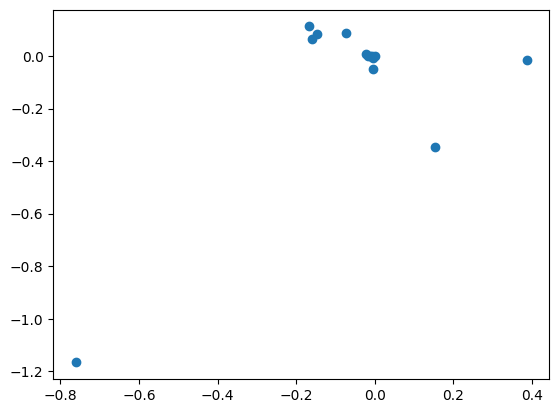

In [31]:
nca_pipeline.A

print(nca_pipeline.A)

plt.scatter(nca_pipeline.A.detach().cpu().numpy()[0], nca_pipeline.A.detach().cpu().numpy()[1])

In [34]:
# Transform the train datasets
X_train_transformed = nca_pipeline(X_train)[:40]

# Move the train data back to CPU
X_train_transformed = X_train_transformed.detach().cpu()
y_train = y_train.detach().cpu()

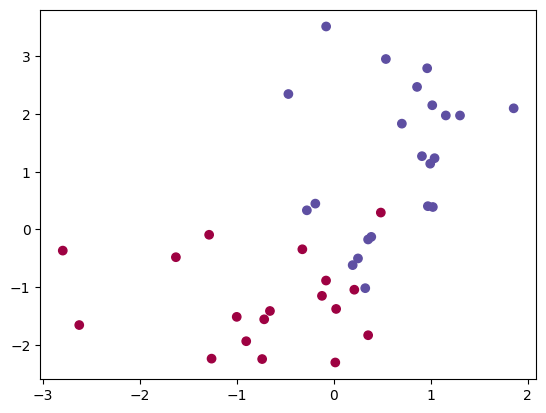

In [36]:
n_train = X_train_transformed.shape[0]
plt.scatter(X_train_transformed[:, 0], X_train_transformed[:, 1], c=y_train[:40], cmap=plt.cm.Spectral)

In [37]:
X_train_transformed[:40].shape

torch.Size([40, 2])

In [38]:
nca_pipeline._pairwise_l2_sq(X_train_transformed[:40])

tensor([[0.0000e+00, 1.6423e-02, 7.6450e+00,  ..., 6.0536e-01, 9.0233e+00,
         2.2269e-01],
        [1.6423e-02, 0.0000e+00, 6.9554e+00,  ..., 8.1638e-01, 9.5888e+00,
         1.1874e-01],
        [7.6450e+00, 6.9554e+00, 0.0000e+00,  ..., 1.2514e+01, 2.7466e+01,
         5.2583e+00],
        ...,
        [6.0536e-01, 8.1638e-01, 1.2514e+01,  ..., 0.0000e+00, 7.0911e+00,
         1.5568e+00],
        [9.0233e+00, 9.5888e+00, 2.7466e+01,  ..., 7.0911e+00, 0.0000e+00,
         1.1065e+01],
        [2.2269e-01, 1.1874e-01, 5.2583e+00,  ..., 1.5568e+00, 1.1065e+01,
         0.0000e+00]])

In [39]:
pij_X_train = pij_X_train.detach()

In [40]:
pij_X_train.shape

torch.Size([40, 40])

In [41]:
torch.all(pij_X_train.transpose(0, 1) == pij_X_train)

tensor(False)

In [42]:
N = pij_X_train.shape[0]
print(N)
M = (N * (N + 1)) // 2
print(M)

40
820


In [43]:
with open('data/pij.mtx', 'w') as file:
    file.write('%%MatrixMarket matrix coordinate double symmetric\n')
    # file.write('%%MatrixMarket matrix coordinate pattern symmetric\n')
    file.write('%pij graph for SDP community detection\n')
    file.write(f"{N} {N} {M}\n")

    for i in range(N):
        for j in range(i, N):
            file.write(f"{i + 1} {j + 1} {pij_X_train[i][j]}")
            # file.write(f"{i + 1} 5 {i}")
            # file.write(f"{i + 1} 5")
            if (i != N - 1 or j != N - 1): file.write("\n")